In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torchaudio
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from torchsummary import summary
import utils.preprocessor as preprocessor
plt.style.use("ggplot")
torch.manual_seed(42)

# Speech Classification Pipeline
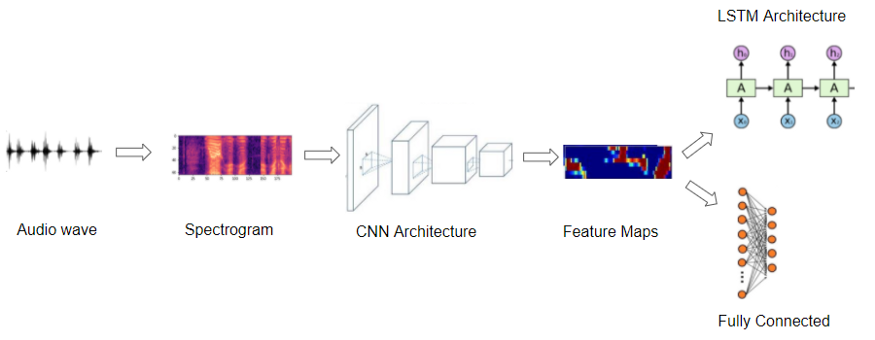

source: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504

## Data exploration

Let's explore some meta information from one sample from each class.

In [30]:
# accents_path = "../audio"
accents_path = "../resource/audio"

../resource/audio/english1.wav >>> 


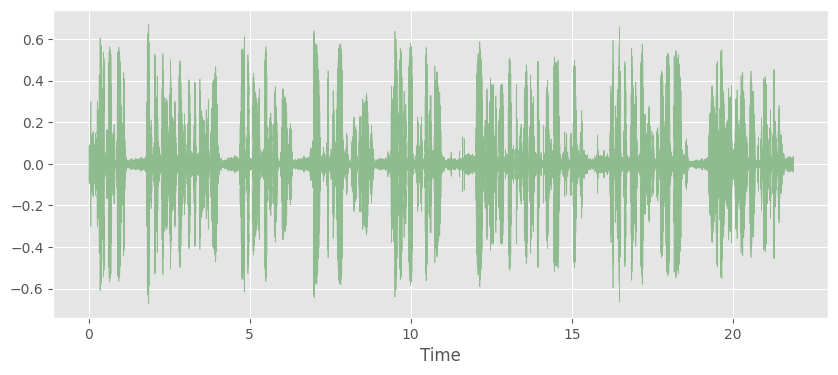

In [35]:
for i, accent_dir in enumerate(os.listdir(accents_path)):
    dir_path = accents_path + "/"
    for file in os.listdir(dir_path):
        file_path = dir_path + file
        print(file_path + " >>> ")
        # print(torchaudio.info(file_path))
        x, sr = librosa.load(file_path)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(x, sr=sr, color="darkseagreen")
        plt.show()
        break

As we can see, some sound files are mono -- 1 audio channel, and some are stereos -- 2 audio channels. Since the classification model expects all items to have the exact dimensions, we can convert the mono files to stereo by duplicating the first channel to the second.
Also, some sound files are sampled at a sample rate of 48000 Hz, and the others at a rate of 22050 Hz. It means that 1 second of audio will have an array size of 48000 for some sound files, while it will have a smaller array size of 22050 for the others. We can see that from the difference in the number of frames. Therefore, we must standardize and convert all audio to the same sampling rate so that all arrays have the exact dimensions.

## Prepare the dataframe with dataset

In [23]:
# create a dataframe for further usage
rows = []
for i, accent_dir in enumerate(os.listdir(accents_path)):
    dir_path = accents_path + "/"
    # for file in os.listdir(dir_path):
    # print(accents_path + "/" + accent_dir)
    rows.append([accents_path + "/" + accent_dir, i, accent_dir])

df = pd.DataFrame(rows, columns=["file_path", "class_id", "class_name"])
df.head(10)

,file_path,class_id,class_name
0,../audio/english142.mp3,0,english142.mp3
1,../audio/english39.mp3,1,english39.mp3
2,../audio/english11.mp3,2,english11.mp3
3,../audio/english10.mp3,3,english10.mp3
4,../audio/english38.mp3,4,english38.mp3
5,../audio/english143.mp3,5,english143.mp3
6,../audio/english141.mp3,6,english141.mp3
7,../audio/english12.mp3,7,english12.mp3
8,../audio/english13.mp3,8,english13.mp3
9,../audio/english140.mp3,9,english140.mp3


## Data preprocessing

In [36]:
class SpeechDataset(Dataset):
    def __init__(self, data_fr, data_path):
        self.data_fr = data_fr
        self.data_path = str(data_path)

    def __len__(self):
        return len(self.data_fr)

    def __getitem__(self, idx):
        audio_file = self.data_path + self.data_fr.loc[idx, "file_path"]
        class_id = self.data_fr.loc[idx, "class_id"]
        aud = preprocessor.load_audio(audio_file)
        rechannel = preprocessor.double_channel(aud)
        downsampl = preprocessor.downsample(rechannel)
        timed = preprocessor.append_trunc(downsampl)
        specgram = preprocessor.spectro_mfcc(timed)
        return specgram, class_id

In [37]:
speech_dataset = SpeechDataset(df, accents_path)

# Random split of 80:20 between training and validation
num_items = len(speech_dataset)
num_train = round(num_items * 0.7)
num_val = num_items - num_train
train_ds, val_ds = random_split(speech_dataset, [num_train, num_val])
# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=15, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=15, shuffle=False)

In [38]:
num_train

108

In [39]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [40]:
for i in range(5):
    plot_spectrogram(train_ds[i][0][0])

LibsndfileError: Error opening '../resource/audio../audio/english74.mp3': System error.

## Classifier model

In [41]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.dropout = nn.Dropout(0.5)
        self.lin = nn.Linear(in_features=32, out_features=9)

    def forward(self, inp_x):
        inp_x = self.conv(inp_x)
        inp_x = self.ap(inp_x)
        inp_x = inp_x.view(inp_x.shape[0], -1)
        inp_x = self.dropout(inp_x)
        inp_x = self.lin(inp_x)
        return inp_x

In [42]:
class AccuracyMetric:
    def __init__(self):
        self.correct, self.total = None, None
        self.reset()

    def update(self, y_pred, y_true):
        self.correct += torch.sum(y_pred.argmax(-1) == y_true).item()
        self.total += y_true.size(0)

    def compute(self):
        return self.correct / self.total

    def reset(self):
        self.correct = 0
        self.total = 0

## Training and Inference

In [46]:
# Create the model and put it on the GPU if available
model = AudioClassifier()
device = torch.device("cpu")
model = model.to(device)
next(model.parameters()).device
summary(model, (2, 64, 258), 11)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [11, 8, 32, 129]             152
              ReLU-2           [11, 8, 32, 129]               0
       BatchNorm2d-3           [11, 8, 32, 129]              16
            Conv2d-4           [11, 16, 16, 65]           1,168
              ReLU-5           [11, 16, 16, 65]               0
       BatchNorm2d-6           [11, 16, 16, 65]              32
            Conv2d-7            [11, 32, 8, 33]           4,640
              ReLU-8            [11, 32, 8, 33]               0
       BatchNorm2d-9            [11, 32, 8, 33]              64
AdaptiveAvgPool2d-10             [11, 32, 1, 1]               0
          Dropout-11                   [11, 32]               0
           Linear-12                    [11, 9]             297
Total params: 6,369
Trainable params: 6,369
Non-trainable params: 0
-----------------------------------

In [49]:
train_dl

In [50]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 5

# training loop
train_loss_history = []
train_accuracy_history = []

valid_loss_history = []
valid_accuracy_history = []

accuracy = AccuracyMetric()

for epoch in range(1, epochs + 1):
    print(f"[INFO] Epoch: {epoch}")
    model.train()

    batch_train_loss = []
    batch_valid_loss = []
    break;

    for X_batch, y_batch in tqdm(train_dl):
        # perform single training step
        model.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_predicted = model(X_batch)

        loss = criterion(y_predicted, y_batch)
        loss.backward()
        optimizer.step()
        accuracy.update(y_predicted, y_batch)
        batch_train_loss.append(loss.item())
    break;

    mean_epoch_loss_train = np.mean(batch_train_loss)
    train_accuracy = accuracy.compute()

    train_loss_history.append(mean_epoch_loss_train)
    train_accuracy_history.append(train_accuracy)
    accuracy.reset()

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_predicted = model(X_batch)

            loss_val = criterion(y_predicted, y_batch)

            accuracy.update(y_predicted, y_batch)
            batch_valid_loss.append(loss_val.item())

    mean_epoch_loss_valid = np.mean(batch_valid_loss)
    valid_accuracy = accuracy.compute()

    valid_loss_history.append(mean_epoch_loss_valid)
    valid_accuracy_history.append(valid_accuracy)
    accuracy.reset()

    print(
        f"Train loss: {mean_epoch_loss_train:0.4f}, Train accuracy: {train_accuracy: 0.4f}"
    )
    print(
        f"Validation loss: {mean_epoch_loss_valid:0.4f}, Validation accuracy: {valid_accuracy: 0.4f}"
    )

[INFO] Epoch: 1


NameError: name 'train_loss_history' is not defined

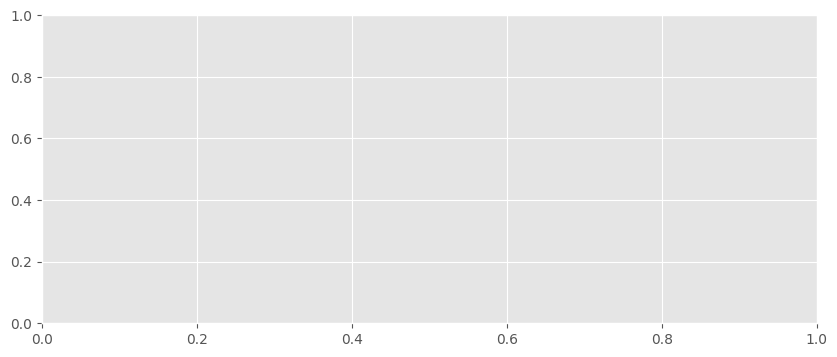

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_loss_history, color="r")
plt.xticks(range(epochs))
plt.plot(valid_loss_history, color="b")
plt.xticks(range(epochs))
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Learning Curve")
ax.grid(True)

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_accuracy_history)
plt.xticks(range(epochs))
plt.plot(valid_accuracy_history)
plt.xticks(range(epochs))

plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Learning Curve")
ax.grid(True)